[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/05-dimensionality-reduction/dimensionality-reduction.ipynb)

In [ ]:
! pip install -q pycse nbconvert umap-learn
from pycse.colab import pdf

# Module 05: Dimensionality Reduction

Techniques for exploring and visualizing high-dimensional data.

## Learning Objectives

1. Understand why dimensionality reduction is useful
2. Apply PCA for linear dimensionality reduction
3. Use t-SNE for visualization
4. Use UMAP for visualization and preprocessing
5. Interpret reduced representations
6. Apply to chemical engineering datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```{index} dimensionality reduction, curse of dimensionality
```


## The Curse of Dimensionality

Real datasets in chemical engineering often have many features:
- **Process data**: A modern chemical plant might have 100-500 sensors recording temperature, pressure, flow rates, compositions, and control signals every second
- **Spectroscopy**: NIR or Raman spectra contain 1000s of wavelengths, each potentially carrying information about composition
- **Molecular descriptors**: Cheminformatics representations of molecules can include 100s of computed properties (molecular weight, LogP, topological indices, etc.)
- **Simulation data**: CFD or molecular dynamics outputs can have millions of degrees of freedom

### Why is high dimensionality a problem?

1. **Visualization**: We can only see in 2D (plots) or 3D. How do you "look at" 100-dimensional data?

2. **Sparsity**: In high dimensions, data points become increasingly isolated. With 10 features, you need exponentially more samples to achieve the same "density" of coverage as in 2D. This makes it harder to find patterns.

3. **Correlation**: Many features are often redundant. In a reactor, temperature at sensor 1 and sensor 2 may be highly correlated - they're not truly independent pieces of information.

4. **Overfitting**: Models with many features relative to samples can memorize noise rather than learning true patterns.

**Dimensionality reduction** addresses these problems by finding a lower-dimensional representation that preserves the important structure in your data. The key question is: what do we mean by "important"? Different methods make different choices here.

In [2]:
# Load catalyst characterization dataset
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/catalyst_characterization.csv"
df = pd.read_csv(url)

# Extract features and labels
feature_names = ['surface_area', 'pore_volume', 'acidity', 'crystallite_size',
                 'metal_dispersion', 'reduction_temp', 'impurity_level', 'particle_size']
X = df[feature_names].values
y = df['catalyst_type'].values

print(f"Dataset shape: {X.shape}")
print(f"Catalyst types: {np.unique(y)}")
df.head()

Dataset shape: (200, 8)
Catalyst types: ['Type_A' 'Type_B' 'Type_C']


,surface_area,pore_volume,acidity,crystallite_size,metal_dispersion,reduction_temp,impurity_level,particle_size,catalyst_type
0,74.698093,68.974690,0.823858,321.212872,22.173454,1.650748,0.028675,1.983167,Type_C
1,112.370161,42.867606,0.827042,359.237136,29.912587,0.967211,0.046187,2.542165,Type_A
2,69.424984,65.322273,0.887644,399.046255,19.909195,1.532541,0.031537,2.108698,Type_C
3,80.224796,61.620391,0.971071,365.102131,17.806495,1.397655,0.032663,2.121097,Type_C
4,92.797020,48.650331,0.788523,318.510113,28.122352,1.207878,0.055846,2.718329,Type_A


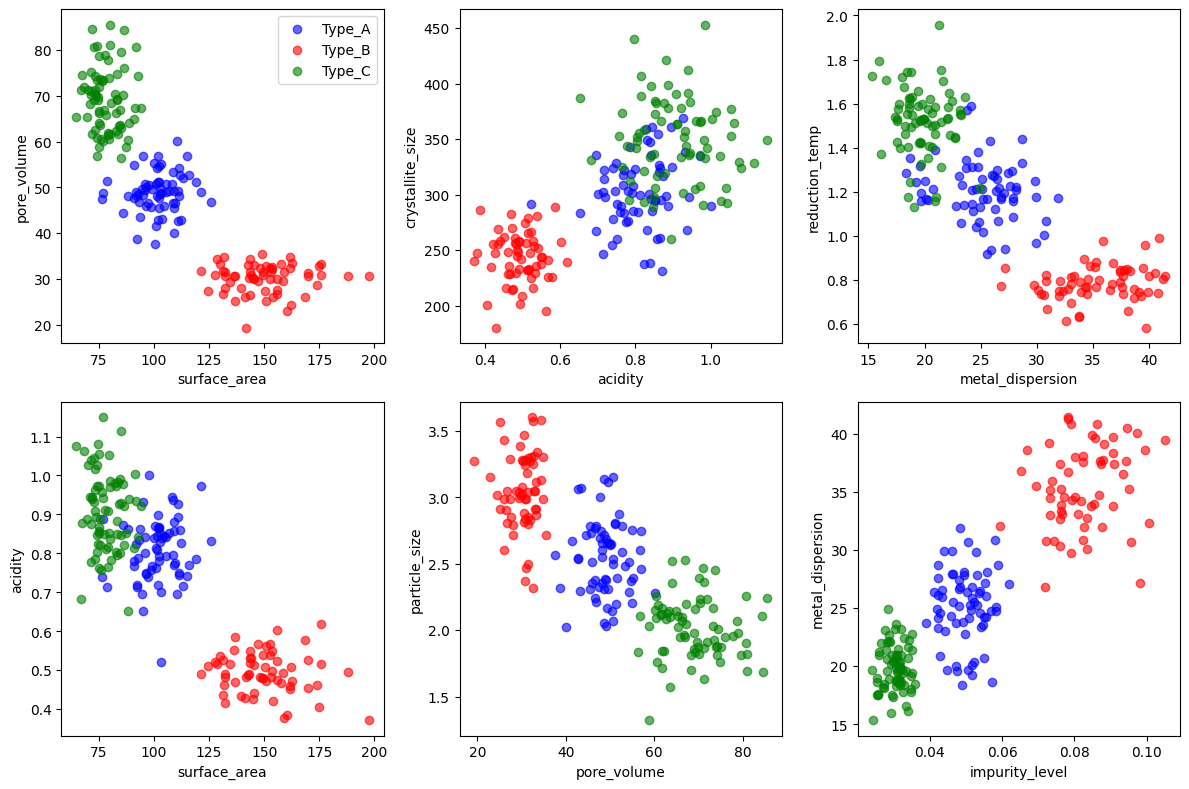

In [3]:
# Visualizing 8 dimensions is hard!
# Let's look at pairwise relationships
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

colors = {'Type_A': 'blue', 'Type_B': 'red', 'Type_C': 'green'}

pairs = [('surface_area', 'pore_volume'), ('acidity', 'crystallite_size'),
         ('metal_dispersion', 'reduction_temp'), ('surface_area', 'acidity'),
         ('pore_volume', 'particle_size'), ('impurity_level', 'metal_dispersion')]

for ax, (x, y) in zip(axes.flat, pairs):
    for cat in ['Type_A', 'Type_B', 'Type_C']:
        mask = df['catalyst_type'] == cat
        ax.scatter(df.loc[mask, x], df.loc[mask, y], c=colors[cat], label=cat, alpha=0.6)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

axes[0, 0].legend()
plt.tight_layout()
plt.show()

### The limits of pairwise visualization

The plots above show 6 of the possible 28 pairwise combinations of our 8 features. Already we can see some separation between catalyst types, but:

- We're missing information by only looking at 2 features at a time
- Some pairs show good separation, others don't - which view is "right"?
- With 100 features, we'd have 4,950 pairs - impossible to examine manually
- Patterns that exist in the *combination* of many features are invisible in 2D slices

This is exactly why we need dimensionality reduction: to find a single 2D view that captures the most important structure from *all* features simultaneously.

```{index} PCA, principal component analysis, explained variance
```


## Principal Component Analysis (PCA)

PCA is the workhorse of dimensionality reduction. It finds new axes (principal components) that are:
1. **Orthogonal** to each other (uncorrelated)
2. **Ordered by variance** - PC1 captures the most variance, PC2 the second most, etc.

### The key idea
PCA asks: "If I could only keep one direction in my data, which direction would preserve the most information?" The answer is the direction of maximum variance. Then it asks the same question for the remaining directions, subject to being perpendicular to the ones already chosen.

### Why variance?
This is a **design choice** with consequences. PCA assumes that variance = information. This works well when:
- Differences between samples are spread across many features
- Noise is relatively small compared to signal
- The interesting structure is *linear* (lies along straight lines/planes)

It works poorly when:
- The interesting structure is nonlinear (curved manifolds)
- Important differences are subtle compared to unimportant large variations
- Outliers dominate the variance

### The critical choice: to scale or not to scale?

Before applying PCA, we must decide whether to standardize our features. This choice matters enormously:

**Without scaling**: Features with larger numerical ranges dominate. If surface area ranges from 50-200 m²/g but impurity level ranges from 0.01-0.1 wt%, PCA will essentially ignore impurities - they contribute almost nothing to total variance.

**With scaling** (StandardScaler): Each feature is transformed to have mean=0 and std=1. Now all features contribute equally *by default*, and PCA finds directions of maximum variance in this normalized space.

**Which should you choose?**
- **Scale** when features have different units or vastly different ranges (most common case)
- **Don't scale** when features are already comparable and you want to preserve natural importance (e.g., all features are concentrations in the same units)

In chemical engineering, we almost always scale because we're combining heterogeneous measurements (temperatures, pressures, compositions, etc.).

In [4]:
# Prepare data: extract features and scale
X = df[feature_names].values
y = df['catalyst_type'].values

# Scaling is important for PCA!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Mean of scaled data: {X_scaled.mean(axis=0).round(2)}")
print(f"Std of scaled data: {X_scaled.std(axis=0).round(2)}")

Original shape: (200, 8)
Mean of scaled data: [-0.  0.  0.  0.  0. -0.  0. -0.]
Std of scaled data: [1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print("Explained variance ratio per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.3f} ({var*100:.1f}%)")

print(f"\nCumulative variance with 2 components: {pca.explained_variance_ratio_[:2].sum():.1%}")

Explained variance ratio per component:
  PC1: 0.836 (83.6%)
  PC2: 0.045 (4.5%)
  PC3: 0.033 (3.3%)
  PC4: 0.025 (2.5%)
  PC5: 0.020 (2.0%)
  PC6: 0.017 (1.7%)
  PC7: 0.015 (1.5%)
  PC8: 0.010 (1.0%)

Cumulative variance with 2 components: 88.0%


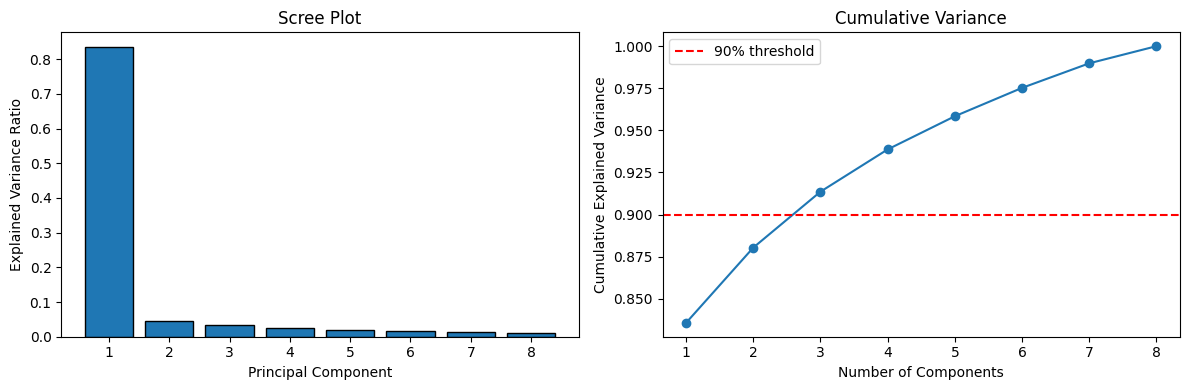

In [6]:
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_, edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')

# Cumulative variance
cumulative = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative) + 1), cumulative, 'o-')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()

plt.tight_layout()
plt.show()

```{index} scree plot
```


### How many components should you keep?

This is one of the most common questions in PCA, and there's no single right answer. Here are common strategies:

1. **Explained variance threshold** (e.g., 90% or 95%): Keep enough components to explain a target amount of variance. This is arbitrary but practical.

2. **Scree plot "elbow"**: Look for where the explained variance drops off sharply. Components before the elbow capture "signal"; those after capture "noise."

3. **Kaiser criterion**: Keep components with eigenvalue > 1 (only for scaled data). This means keeping components that explain more variance than a single original variable.

4. **Cross-validation**: If using PCA for preprocessing before a predictive model, choose the number of components that gives best prediction performance.

**The tradeoff**: More components = more information preserved, but also more complexity and potential noise. Fewer components = simpler, more robust representation, but you may lose important details.

For visualization, we're usually stuck with 2 or 3 components. For preprocessing, use the cumulative variance plot to guide your choice.

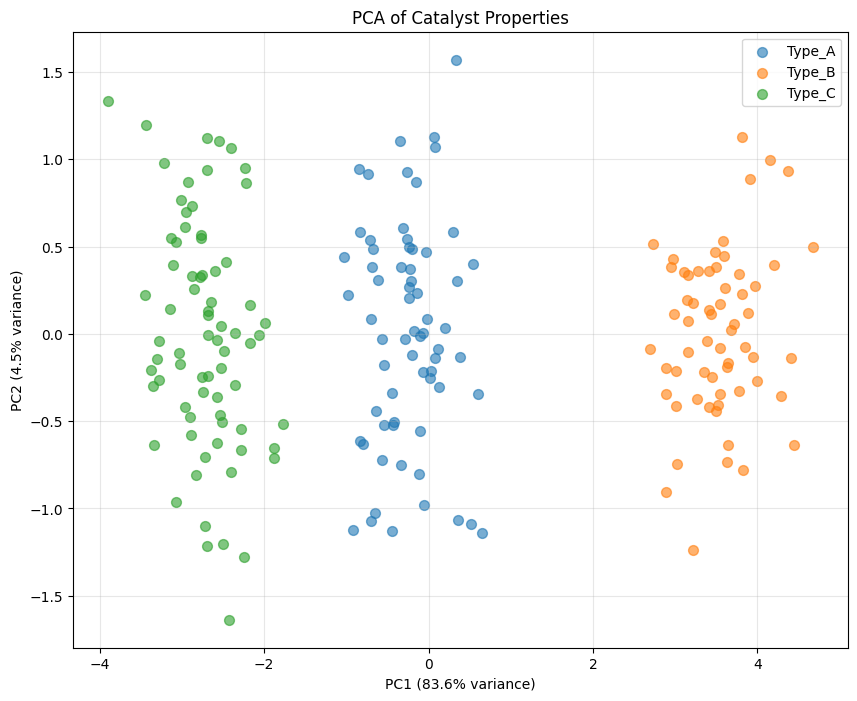

In [7]:
# Visualize in 2D
plt.figure(figsize=(10, 8))

for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cat, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA of Catalyst Properties')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Interpret principal components: loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(feature_names))],
    index=feature_names
)

print("PC Loadings (contribution of each feature):")
print(loadings[['PC1', 'PC2', 'PC3']].round(3))

PC Loadings (contribution of each feature):
                    PC1    PC2    PC3
surface_area      0.362  0.070 -0.228
pore_volume      -0.365 -0.031 -0.117
acidity          -0.349 -0.026  0.639
crystallite_size -0.323  0.868 -0.300
metal_dispersion  0.360  0.087 -0.151
reduction_temp   -0.359 -0.077 -0.114
impurity_level    0.371  0.043 -0.086
particle_size     0.338  0.474  0.627


```{index} loadings
```


### Interpreting PCA: What do the components mean?

A major advantage of PCA over other methods is **interpretability**. The loadings tell us how each original feature contributes to each principal component.

**Reading the loadings table:**
- Large positive loading: feature increases as PC increases
- Large negative loading: feature decreases as PC increases  
- Near-zero loading: feature doesn't contribute much to this PC

**What to look for:**
- Features with similar loadings are correlated and "move together"
- Features with opposite signs are anti-correlated
- PC1 often represents overall "size" or "magnitude" if many loadings have the same sign
- Later PCs often capture contrasts between groups of features

The biplot below shows both samples and loadings together, making it easier to see which features drive the separation between groups.

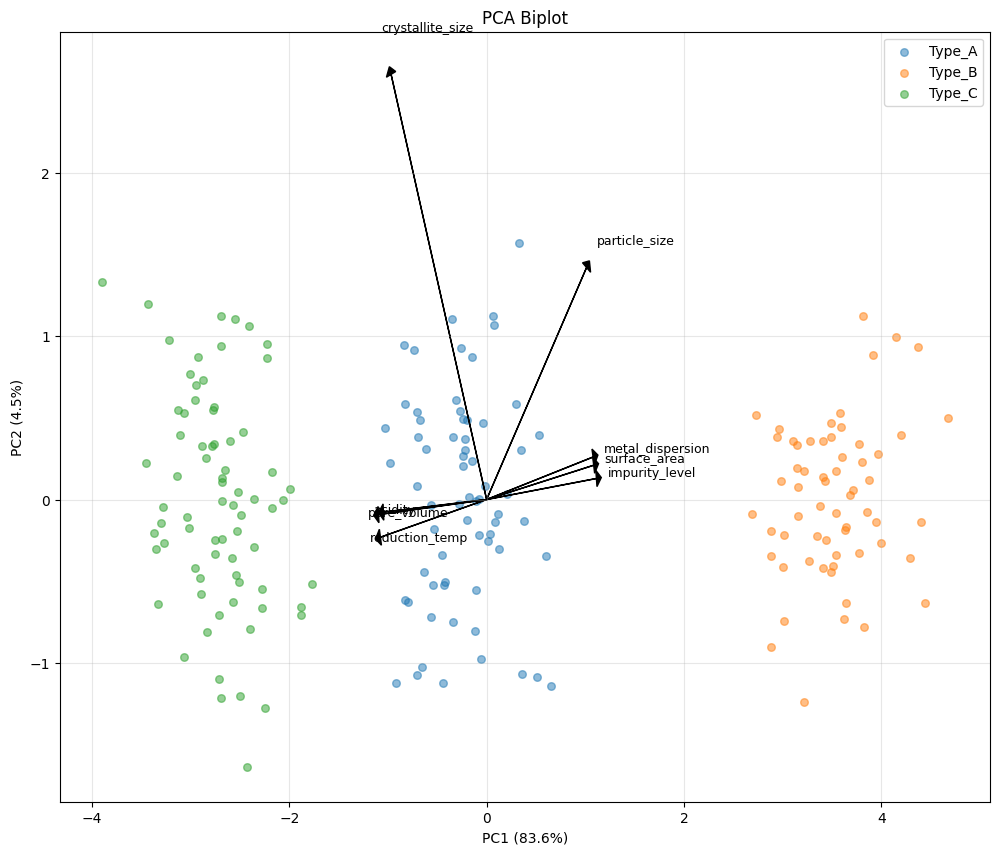

In [9]:
# Biplot: visualize samples and loadings together
fig, ax = plt.subplots(figsize=(12, 10))

# Plot samples
for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cat, alpha=0.5, s=30)

# Plot loadings as arrows
scale = 3  # Scale factor for visibility
for i, feature in enumerate(feature_names):
    ax.arrow(0, 0, loadings.iloc[i, 0]*scale, loadings.iloc[i, 1]*scale,
             head_width=0.1, head_length=0.05, fc='black', ec='black')
    ax.text(loadings.iloc[i, 0]*scale*1.1, loadings.iloc[i, 1]*scale*1.1, 
            feature, fontsize=9)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA Biplot')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

```{index} t-SNE
```


## t-SNE: When Linear Isn't Enough

PCA has a fundamental limitation: it can only find linear structure. If your data lies on a curved surface (a "manifold") in high-dimensional space, PCA will fail to capture that structure.

**t-SNE** (t-distributed Stochastic Neighbor Embedding) addresses this by focusing on a different goal: preserve *local neighborhoods*. Points that are close together in the original space should remain close in the reduced space.

### How t-SNE works (intuition)
1. Compute pairwise similarities in high-dimensional space (who are each point's neighbors?)
2. Create a random 2D layout
3. Iteratively adjust the 2D positions to match the high-dimensional neighborhood relationships

### The key tradeoff
t-SNE sacrifices **global structure** for **local structure**. This means:
- Clusters are usually well-separated and visually clear
- But distances *between* clusters are meaningless
- The overall arrangement of clusters is arbitrary

**Important**: Never interpret t-SNE distances! Two clusters that appear far apart might actually be similar. Two that appear close might be very different. Only the *within-cluster* structure is meaningful.

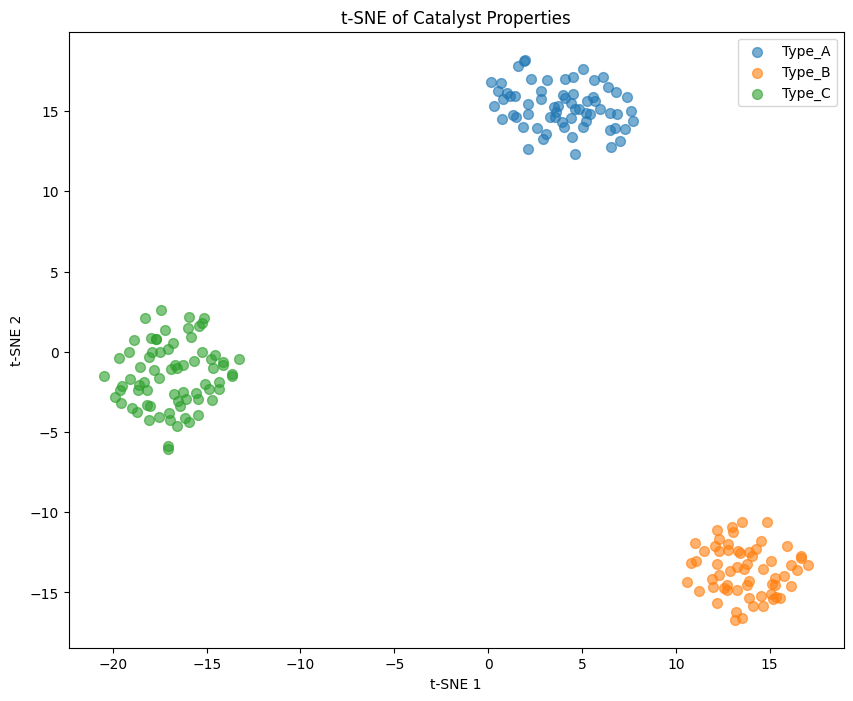

In [10]:
# Fit t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize
plt.figure(figsize=(10, 8))

for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cat, alpha=0.6, s=50)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Catalyst Properties')
plt.legend()
plt.show()

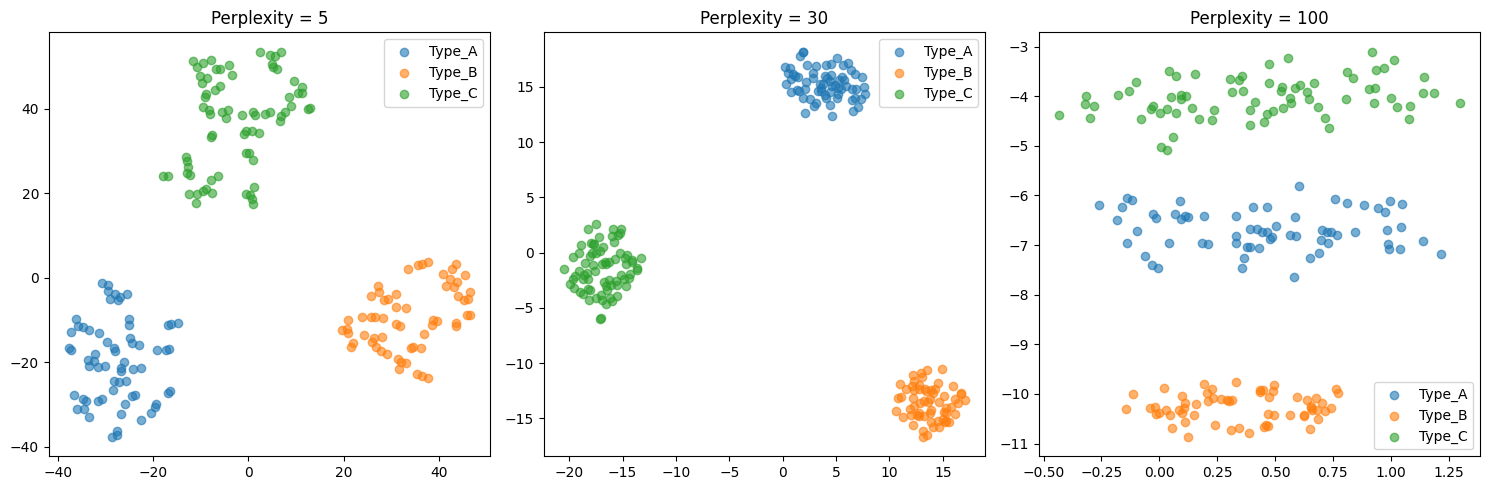

In [11]:
# Effect of perplexity
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, perp in zip(axes, [5, 30, 100]):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    for cat in ['Type_A', 'Type_B', 'Type_C']:
        mask = y == cat
        ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cat, alpha=0.6)
    
    ax.set_title(f'Perplexity = {perp}')
    ax.legend()

plt.tight_layout()
plt.show()

```{index} perplexity
```


### Choosing perplexity: the local vs global tradeoff

Perplexity is t-SNE's main hyperparameter. It roughly corresponds to "how many neighbors should each point consider?"

- **Low perplexity (5-10)**: Focus on very local structure. You'll see tight, fragmented clusters. Good for finding fine-grained substructure, but may split natural groups.

- **Medium perplexity (30-50)**: The typical default. Balances local and broader structure. Usually a good starting point.

- **High perplexity (100+)**: Consider more neighbors, capturing broader patterns. Clusters may merge. Can approach PCA-like behavior at very high values.

**Practical advice:**
- Start with perplexity = 30 (or n_samples/3 if you have few samples)
- If clusters look too fragmented, increase perplexity
- If distinct groups are merging, decrease perplexity
- Always try multiple values - t-SNE results can be sensitive to this choice
- Perplexity must be less than n_samples

```{index} UMAP
```


## UMAP: The Best of Both Worlds?

UMAP (Uniform Manifold Approximation and Projection) was developed in 2018 and has quickly become the go-to method for visualization. It addresses many of t-SNE's limitations:

### Why UMAP often beats t-SNE

1. **Speed**: UMAP is significantly faster, especially on large datasets (10,000+ points)
2. **Global structure**: Unlike t-SNE, UMAP tries to preserve relationships between clusters, not just within them
3. **Reproducibility**: With a fixed random seed, UMAP gives consistent results
4. **New data**: UMAP can transform new points using a fitted model (t-SNE cannot)
5. **Preprocessing**: UMAP embeddings can be used as features for downstream ML models

### The tradeoffs

- **Less interpretable than PCA**: No loadings or explained variance
- **Hyperparameter sensitive**: Results depend on `n_neighbors` and `min_dist`
- **Still nonlinear**: Can distort distances, though less than t-SNE
- **Newer = less proven**: PCA has decades of theoretical backing; UMAP is more empirical

### When to use UMAP

UMAP is often the best default choice for visualization when:
- You have more than a few hundred samples
- You want to see both cluster structure and relationships between clusters
- You might need to project new data later
- Speed matters

/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


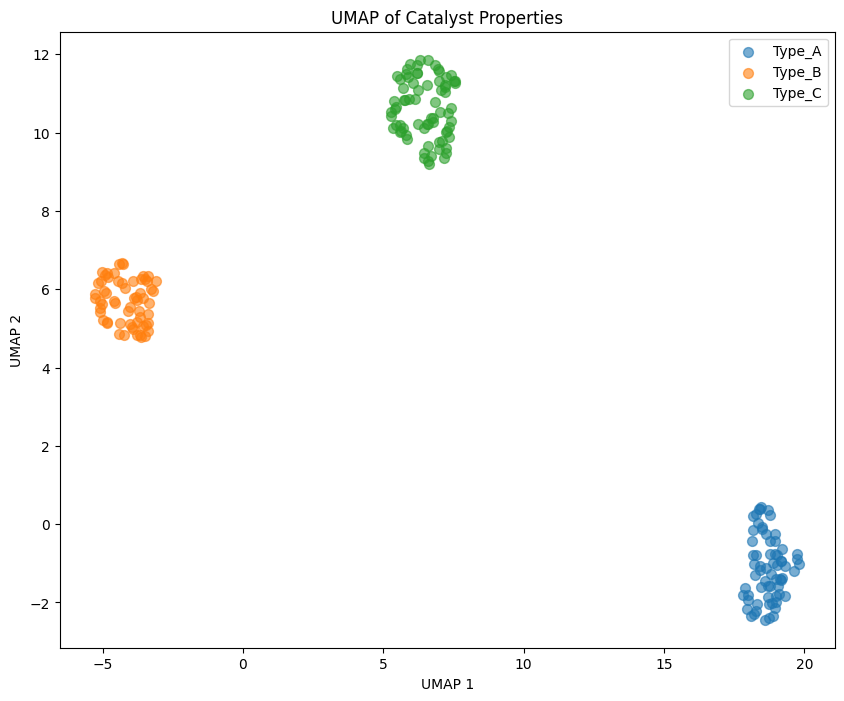

In [12]:
# Fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Visualize
plt.figure(figsize=(10, 8))

for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=cat, alpha=0.6, s=50)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Catalyst Properties')
plt.legend()
plt.show()

/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


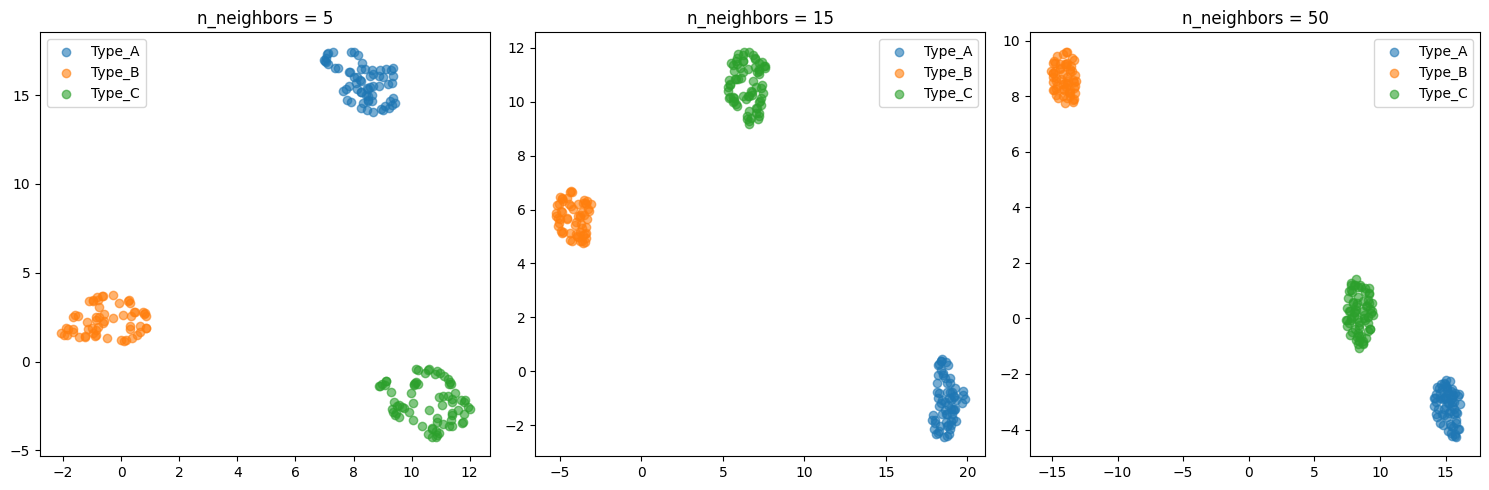

In [13]:
# Effect of n_neighbors parameter
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, n_neighbors in zip(axes, [5, 15, 50]):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    
    for cat in ['Type_A', 'Type_B', 'Type_C']:
        mask = y == cat
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], label=cat, alpha=0.6)
    
    ax.set_title(f'n_neighbors = {n_neighbors}')
    ax.legend()

plt.tight_layout()
plt.show()

### UMAP's key parameters

UMAP has two main hyperparameters that control the embedding:

**`n_neighbors`** (similar to t-SNE's perplexity):
- Controls the balance between local and global structure
- Low values (5-15): Emphasize local structure, tighter clusters
- High values (50-200): Emphasize global structure, more spread out
- Default of 15 works well for most cases

**`min_dist`** (unique to UMAP):
- Controls how tightly points can be packed together
- Low values (0.0-0.1): Points can clump tightly, good for seeing cluster density
- High values (0.5-1.0): Points spread out more uniformly, better for seeing individual points
- Default of 0.1 is usually good

**Practical advice:**
- Start with defaults (`n_neighbors=15`, `min_dist=0.1`)
- If clusters are too fragmented, increase `n_neighbors`
- If you can't see individual points, increase `min_dist`
- UMAP is generally less sensitive than t-SNE to parameter choices

## PCA vs t-SNE vs UMAP

| Aspect | PCA | t-SNE | UMAP |
|--------|-----|-------|------|
| Type | Linear | Nonlinear | Nonlinear |
| Preserves | Global structure | Local structure | Local + global |
| Interpretable | Yes (loadings) | No | No |
| Speed | Fast | Slow | Fast |
| New data | Can project | Cannot project | Can project |
| Use for | Features, preprocessing | Visualization | Visualization, preprocessing |

/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


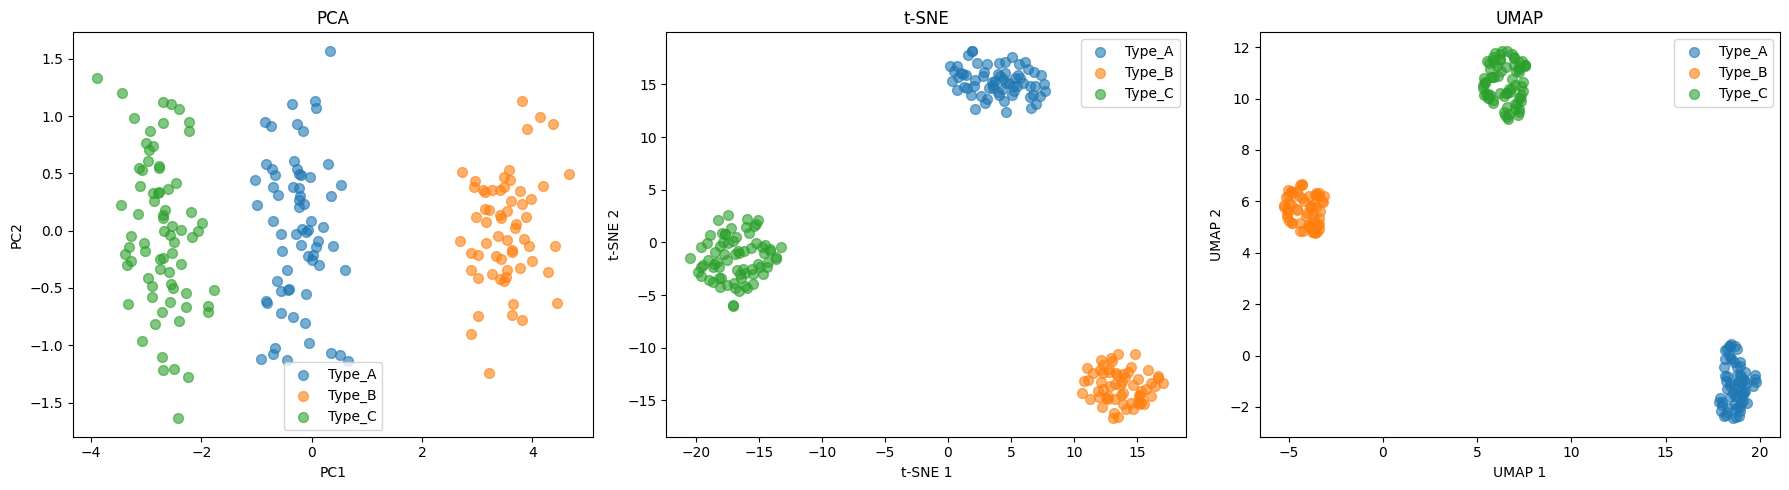

In [14]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], label=cat, alpha=0.6, s=50)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA')
axes[0].legend()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=cat, alpha=0.6, s=50)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE')
axes[1].legend()

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

for cat in ['Type_A', 'Type_B', 'Type_C']:
    mask = y == cat
    axes[2].scatter(X_umap[mask, 0], X_umap[mask, 1], label=cat, alpha=0.6, s=50)
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].set_title('UMAP')
axes[2].legend()

plt.tight_layout()
plt.show()

In [15]:
# Keep components that explain 90% of variance
pca_90 = PCA(n_components=0.90)
X_reduced = pca_90.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"Reduced features: {X_reduced.shape[1]}")
print(f"Explained variance: {pca_90.explained_variance_ratio_.sum():.1%}")

Original features: 8
Reduced features: 3
Explained variance: 91.4%


## How to Choose: A Decision Guide

With three methods available, how do you decide which to use? Here's a practical decision tree:

### What's your goal?

**1. "I need to reduce features for a downstream model"**
→ Use **PCA**. It's fast, deterministic, and you can choose how much variance to keep. The reduced features are uncorrelated, which helps many ML algorithms.

**2. "I need to understand which original features matter"**
→ Use **PCA**. It's the only method with interpretable loadings. You can explain what each component represents.

**3. "I just want to visualize clusters in my data"**
→ Use **UMAP** first. It's fast and usually gives good results. Fall back to t-SNE if UMAP doesn't show clear structure.

**4. "I need to project new data points onto an existing visualization"**
→ Use **UMAP** or **PCA**. t-SNE cannot transform new points.

**5. "I have a huge dataset (>100,000 samples)"**
→ Use **PCA** or **UMAP**. t-SNE will be too slow.

### A recommended workflow

1. **Always start with PCA** - it's fast and gives you explained variance as a sanity check
2. **If PCA shows good separation** - you might not need anything fancier
3. **If PCA shows overlapping groups** - try UMAP to see if there's nonlinear structure
4. **If you're publishing or presenting** - try multiple methods and show the comparison (as we did above)

### Common pitfalls to avoid

- Don't forget to scale your data (especially for PCA)
- Don't interpret distances in t-SNE plots
- Don't use t-SNE/UMAP coordinates as features without careful validation
- Don't conclude "no structure" from a single t-SNE run with default parameters
- Don't over-interpret small clusters - they might be artifacts of the algorithm

In [16]:
! pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/05-dimensionality-reduction/quizzes/dimensionality-reduction-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources provide deeper understanding of dimensionality reduction techniques:

1. **[Scikit-learn Decomposition](https://scikit-learn.org/stable/modules/decomposition.html)** - Official documentation on PCA, ICA, NMF, and other decomposition methods. Includes mathematical details and practical guidance.

2. **[How to Use t-SNE Effectively (Wattenberg et al.)](https://distill.pub/2016/misread-tsne/)** - An interactive article explaining how t-SNE works and common pitfalls in interpretation. Essential reading before using t-SNE on your data.

3. **[UMAP: Uniform Manifold Approximation and Projection](https://umap-learn.readthedocs.io/en/latest/)** - Official UMAP documentation with excellent explanations of how it differs from t-SNE and when to use each method.

4. **[A Tutorial on Principal Component Analysis (Shlens)](https://arxiv.org/abs/1404.1100)** - Clear mathematical exposition of PCA from first principles. Helps build intuition for what principal components actually represent.

5. **[Visualizing Data using t-SNE (van der Maaten & Hinton, JMLR 2008)](https://www.jmlr.org/papers/v9/vandermaaten08a.html)** - The original t-SNE paper. Readable introduction to the algorithm and its advantages over linear methods like PCA.

## Summary

In this module, we learned three complementary approaches to dimensionality reduction, each with distinct strengths:

| Method | Best For | Key Parameter | Limitation |
|--------|----------|---------------|------------|
| **PCA** | Preprocessing, interpretation, fast exploration | n_components (variance threshold) | Linear only |
| **t-SNE** | Visualizing cluster structure | perplexity (5-100) | Slow, no new data projection |
| **UMAP** | General-purpose visualization | n_neighbors, min_dist | Less interpretable than PCA |

### Key takeaways

1. **Scaling matters**: Always standardize features before applying these methods (unless you have a specific reason not to)

2. **No free lunch**: Each method makes tradeoffs
   - PCA: interpretable but linear
   - t-SNE: great clusters but no global structure
   - UMAP: good balance but still a "black box"

3. **Start simple**: Begin with PCA to understand your data's variance structure, then try nonlinear methods if needed

4. **Be skeptical**: Visualizations can mislead. Don't over-interpret clusters or distances, especially with t-SNE

5. **Try multiple methods**: When presenting results, showing PCA alongside UMAP gives a more complete picture

### Looking ahead

Dimensionality reduction connects to many topics we'll cover later:
- **Regression** (next module): PCA can help when you have many correlated features
- **Clustering**: UMAP/t-SNE visualizations help validate cluster assignments
- **Model interpretability**: PCA loadings reveal which features drive predictions

## Next Steps

Now we'll learn how to build predictive models using linear regression.

---

## The Catalyst Crisis: Chapter 5 - "Finding the Shape of the Problem"

*A story about dimensionality reduction and discovering hidden structure*

---

Two hundred sensor columns stared back from Alex's screen. Two hundred dimensions of data, far too many to visualize or understand.

"The curse of dimensionality," Sam said, looking over her shoulder. "That's what the professor called it. Too many features, not enough signal."

"There has to be structure here," Alex muttered. "Real processes don't have two hundred independent degrees of freedom."

She ran PCA—principal component analysis—and watched the scree plot appear. The first five components captured 85% of the variance. Everything else was noise.

"Five dimensions," she said aloud. "Not two hundred. Five."

But what did those five dimensions mean? PC1 was dominated by temperature-related variables. PC2 by nutrient concentrations. The abstract math was collapsing two hundred measurements into a handful of underlying factors.

Jordan pulled up a chair. He'd been quiet this week, more than usual. "Try t-SNE. It shows clusters better than PCA."

The t-SNE plot appeared on screen, and Alex felt her breath catch. The batches weren't scattered randomly—they clumped into three distinct groups. Three modes of operation that no one had documented.

"Maya, pull up the yield data."

They overlaid the yields on the t-SNE plot. One cluster was almost entirely good batches. One was entirely bad. The third was mixed.

"The reactor has three natural operating regimes," Alex said slowly. "And we've been treating them all as one."

Sam leaned in, finally fully engaged. "What separates them?"

Alex traced the cluster boundaries back to the original features. The answer emerged gradually, like a photograph developing. The bad cluster shared one thing in common: they all used catalyst from lots manufactured in a specific time window.

"It's the catalyst," she said. "Different lots of catalyst push the reactor into different regimes. We've been blaming randomness, but it's the catalyst supply chain."

She added to the mystery board: **Three operating regimes. Bad batches cluster together. Common factor: catalyst lot.**

That night, Professor Pipeline found the team still in the lab, surrounded by plots and printouts.

"Making progress?"

"We found something." Alex pointed to the t-SNE plot. "The batches cluster by catalyst lot. Something about the catalyst is driving the failures."

He nodded slowly. "So what's the next question?"

"Why. What's different about the catalyst lots? What changed?"

"Good." He headed for the door, then paused. "You're thinking like investigators now. Not just analysts."

---

*Continue to the next lecture to follow Alex and the team as they build predictive models...*